In [1]:
import pandas as pd, numpy as np
import imp, re

import z2_save_jaspar, z1_save_oligos, z3_transformations
from scipy.stats import ks_2samp
import scipy.stats as stats
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [2]:

#LOAD JASPAR & OLIGO DATA
jaspar = z2_save_jaspar.load_jaspar()
oligos,oligos_by_exp = z1_save_oligos.load_oligos_plus()
oligos_by_exp["analysis_group_key"] = oligos_by_exp.exp.copy()
all_obe = oligos_by_exp.reset_index().loc[lambda x:x.mutant_num<5].groupby(["starts","mutant_num","analysis_group_key"]).norm_mu.mean()


In [3]:
filters =  z3_transformations.compute_filters(all_obe, hq = False)


/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [4]:
print(f"""{oligos_by_exp.n_bcs.sum()} barcodes,  {oligos_by_exp.n_transcripts.sum()} total UMIs. 
{oligos_by_exp.n_transcripts.sum() / oligos_by_exp.n_bcs.sum()} umis per barcode
{oligos_by_exp.groupby(["oligo","analysis_group_key"]).n_transcripts.sum().mean()}
""")



6698373 barcodes,  15778869 total UMIs. 
2.3556271052686975 umis per barcode
85.35023692068026



In [5]:
tile_sets_nmu = oligos_by_exp.groupby(["starts"]).mean().norm_mu
wt_tiles_nmu = oligos_by_exp.loc[lambda x: x.mutant_num == 0].groupby(["starts"]).mean().norm_mu

e5_tile_starts = oligos_by_exp.loc[lambda x: x.mutant_num == 0]\
    .groupby(["starts"]).mean().loc[lambda x: x.norm_mu >= x.norm_mu.quantile(.95) ].index
e1_tile_starts = oligos_by_exp.loc[lambda x: x.mutant_num == 0]\
    .groupby(["starts"]).mean().loc[lambda x: x.norm_mu > x.norm_mu.quantile(.99) ].index

print(f"""average normalized mu over all tile sets in all experiments {tile_sets_nmu.mean()}
average normalized my over all wildtype tiles {wt_tiles_nmu.mean()}

the 95th percentile value of enmu over all wildtype tiles is {wt_tiles_nmu.quantile(.95)}
the 99th percentile value of enmu over all wiltype tiles is {wt_tiles_nmu.quantile(.99)}

the 95th percentile value of enmu over all tiles is {tile_sets_nmu.quantile(.95)}
the 99th percentile value of enmu over all tiles is {tile_sets_nmu.quantile(.99)}

We will define the e5 and e1 groups using the average expression levels of wild type oligos
being over the 95th and 99th percentiles respectively.

{len(e5_tile_starts)} and {len(e1_tile_starts)} of {oligos_by_exp.starts.nunique()} were identified in 
the e5 and e1 sets respectively.
""")

average normalized mu over all tile sets in all experiments 2.294850676420863
average normalized my over all wildtype tiles 2.3237568953694314

the 95th percentile value of enmu over all wildtype tiles is 3.026028017721101
the 99th percentile value of enmu over all wiltype tiles is 6.562644394613727

the 95th percentile value of enmu over all tiles is 2.951008743282446
the 99th percentile value of enmu over all tiles is 5.371244117961561

We will define the e5 and e1 groups using the average expression levels of wild type oligos
being over the 95th and 99th percentiles respectively.

99 and 20 of 2091 were identified in 
the e5 and e1 sets respectively.



In [6]:
obe_by_start = oligos_by_exp.reset_index().set_index("starts").sort_index()

In [7]:

oligo_types =pd.concat([pd.concat([
obe_by_start.loc[max(mutant_start_position-150,0):mutant_start_position].loc[lambda x: x.mutant_start == mutant_start_position].assign(tile_class="ablation"),
obe_by_start.loc[max(mutant_start_position-150,0):mutant_start_position].loc[lambda x: (x.mutant_num > 0) &(x.mutant_num < 5) & (x.mutant_start != mutant_start_position)].assign(tile_class="other"),    
obe_by_start.loc[max(mutant_start_position-150,0):max(0,mutant_start_position-30)].loc[lambda x: x.mutant_num ==0].assign(tile_class="wildtype"),
obe_by_start.loc[max(mutant_start_position-150,0):mutant_start_position+30].loc[lambda x: (x.mutant_start == mutant_start_position) | 
                                                                                ( (x.mutant_start+30) == mutant_start_position)].assign(tile_class="ablation60"),    
obe_by_start.loc[max(mutant_start_position-150,0):mutant_start_position+30].loc[lambda x: (x.mutant_num > 0) &(x.mutant_num < 5) &
                                                                                ( (x.mutant_start != mutant_start_position) & 
                                                                                ( (x.mutant_start+30) != mutant_start_position))].assign(tile_class="other60"),    
obe_by_start.loc[max(mutant_start_position-150,0):max(0,mutant_start_position)].loc[lambda x: x.mutant_num ==0].assign(tile_class="wildtype60"),
    
    ], ignore_index =True).assign(mutant_tile_start = mutant_start_position) for mutant_start_position in oligos_by_exp.mutant_start.unique()]).set_index(["mutant_tile_start","tile_class"])


In [9]:
oligo_types["starts"] = oligo_types.join(oligos_by_exp.reset_index().drop_duplicates("oligo").set_index("oligo")[["starts"]],on="oligo").starts

In [10]:
oligo_types = oligo_types.sort_index(level=[0,1])

In [11]:
"ablation" in tile_groups.keys

NameError: name 'tile_groups' is not defined

In [381]:
set(["ablation","other","wildtype","ablation60","other60","wildtype60"]).issubset(tile_groups.groups.keys())

False

In [399]:
mutant_starts

array([    0,   150,    30, ..., 25688, 87453, 98130])

In [407]:
pd.Series(mutant_starts, index = mutant_starts).apply(get_stats)

skipping position 397513


TypeError: object of type 'NoneType' has no len()

In [ ]:
stats.ttest_ind( 

In [415]:
stats

<module 'scipy.stats' from '/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/scipy/stats/__init__.py'>

In [444]:
oligos_by_exp["exp"].unique()

array(['DLD1_WT_BR1', 'DLD1_WT_BR2', 'HCT116_Gemcitabine2uM_BR1',
       'HCT116_Gemcitabine2uM_BR2', 'HCT116_WT_BR1', 'HCT116_WT_BR2',
       'U2OS_NFKB1KO_Sorted_GFPneg_BR1_with_ML120B_20uM',
       'U2OS_NFKB1KO_Sorted_GFPneg_BR2_with_ML120B_20uM',
       'U2OS_NFKB1KO_Sorted_GFPpos_BR1', 'U2OS_NFKB1KO_Sorted_GFPpos_BR2',
       'U2OS_NFKB2KO_Sorted_GFPneg_BR1_with_ML120B_20uM',
       'U2OS_NFKB2KO_Sorted_GFPneg_BR2_with_ML120B_20uM',
       'U2OS_NFKB2KO_Sorted_GFPpos_BR1', 'U2OS_NFKB2KO_Sorted_GFPpos_BR2',
       'U2OS_WT_BR1', 'U2OS_WT_BR2'], dtype=object)

In [466]:

#means = pd.Series(mutant_starts).apply(lambda s: oligo_types.loc[idx[s,:],:].groupby("tile_class").norm_mu.mean())

def get_stats(s):
    tile_groups = oligo_types.loc[idx[s,:],:].groupby("tile_class")
    if not set(["ablation","other","wildtype",
                "ablation60","other60","wildtype60"]).issubset(tile_groups.groups.keys()): 
        print (f"skipping position {s}")
        return pd.Series().rename(s)

    ablations = tile_groups.get_group("ablation")
    others = tile_groups.get_group("other")
    wildtypes = tile_groups.get_group("wildtype")
    
    ab1_dld1 = tile_groups.get_group("ablation").loc[lambda x: x.exp=="DLD1_WT_BR1"]
    ot1_dld1 = tile_groups.get_group("other").loc[lambda x: x.exp=="DLD1_WT_BR1"]
    wt1_dld1 = tile_groups.get_group("wildtype").loc[lambda x: x.exp=="DLD1_WT_BR1"]
    
    ab2_dld1 = tile_groups.get_group("ablation").loc[lambda x: x.exp=="DLD1_WT_BR2"]
    ot2_dld1 = tile_groups.get_group("other").loc[lambda x: x.exp=="DLD1_WT_BR2"]
    wt2_dld1 = tile_groups.get_group("wildtype").loc[lambda x: x.exp=="DLD1_WT_BR2"]


    ablations60 = tile_groups.get_group("ablation60")
    others60 = tile_groups.get_group("other60")
    wildtypes60 = tile_groups.get_group("wildtype60")
    
    wt_tt = stats.ttest_ind( ablations.norm_mu, wildtypes.norm_mu)
    all_tt = stats.ttest_ind( ablations.norm_mu, pd.concat([wildtypes.norm_mu,others.norm_mu]))
    
    r1_tt = stats.ttest_ind( ab1_dld1.norm_mu, wt1_dld1.norm_mu)
    r2_tt = stats.ttest_ind( ab2_dld1.norm_mu, wt2_dld1.norm_mu)
    
    r1_aott = stats.ttest_ind( ab1_dld1.norm_mu, pd.concat([wt1_dld1.norm_mu,ot1_dld1.norm_mu]))
    r2_aott = stats.ttest_ind( ab2_dld1.norm_mu, pd.concat([wt2_dld1.norm_mu,ot2_dld1.norm_mu]))
            
        
#     wt_rep_tt = stats.ttest_ind( ablations.norm_mu, wildtypes.norm_mu)
#     all_rep_tt = stats.ttest_ind( ablations.norm_mu, pd.concat([wildtypes.norm_mu,others.norm_mu]))
    
    
    return pd.Series({

        "mu_wt":wildtypes.norm_mu.mean(),
        "mu_ot":others.norm_mu.mean(),
        "mu_ab":ablations.norm_mu.mean(),

        "mu_wt60":wildtypes60.norm_mu.mean(),
        "mu_ot60":others60.norm_mu.mean(),
        "mu_ab60":ablations60.norm_mu.mean(),
        
        "tt_wt_pval":-1 * np.log(wt_tt[1]),
        "tt_all_pval":-1 * np.log(all_tt[1]),
        
                
        "tt_wt_ttstat":wt_tt[0],
        "tt_all_ttstat":all_tt[0],
        
                        
        "tt_r1_ttstat":r1_tt[0],
        "tt_r2_ttstat":r2_tt[0],
                                
        "tt_r1_aottstat":r1_aott[0],
        "tt_r2_aottstat":r2_aott[0],
        
        "tt_r1_aott_pval":-1 * np.log(r1_aott[1]),
        "tt_r2_aott_pval":-1 * np.log(r2_aott[1]),
        
                

    }).rename(s)





In [467]:
enriched_starts = e1_tile_starts
mutant_starts = oligos_by_exp.loc[lambda x: x.starts.isin(enriched_starts)].mutant_start.unique()
e1_stats = pd.Series(mutant_starts, index = mutant_starts).apply(get_stats)


enriched_starts = e5_tile_starts
mutant_starts = oligos_by_exp.loc[lambda x: x.starts.isin(enriched_starts)].mutant_start.unique()
e5_stats = pd.Series(mutant_starts, index = mutant_starts).apply(get_stats)


skipping position 397513
skipping position 254312
skipping position 397513
skipping position 401413
skipping position 431620
skipping position 445396
skipping position 452392
skipping position 534582


In [468]:
import seaborn as sns
%matplotlib inline

ValueError: Could not interpret input 'tt_r1_pval'

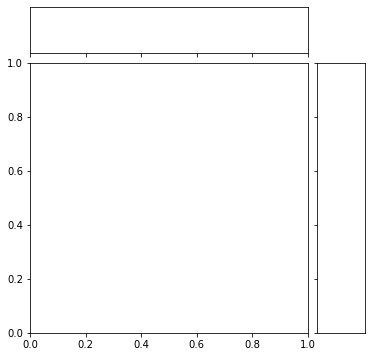

In [470]:
sns.jointplot( x = "tt_r1_aott_pval", y = "tt_r1_pval", data = pd.concat([
    e5_stats.assign(enrichment=0),
    e1_stats.assign(enrichment=1)]))

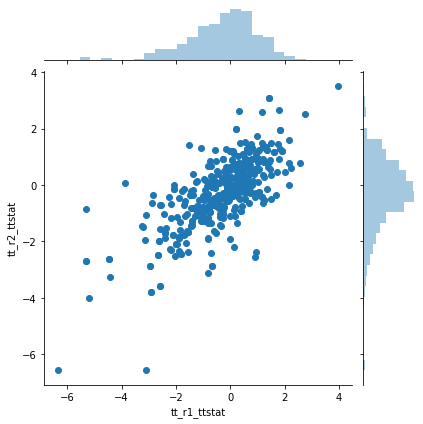

In [457]:
sns.jointplot( x = "tt_r1_ttstat", y = "tt_r2_ttstat", data = pd.concat([
    e5_stats.assign(enrichment=0),
    e1_stats.assign(enrichment=1)]))

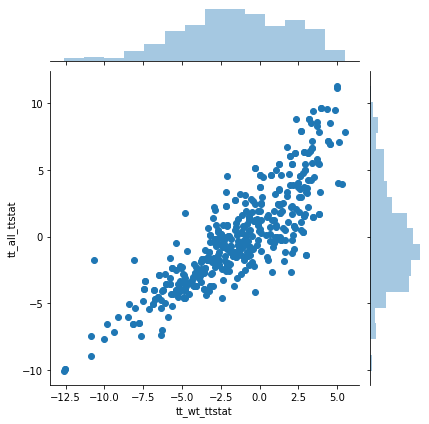

In [442]:
sns.jointplot( x = "tt_wt_ttstat", y = "tt_all_ttstat", data = pd.concat([
    e5_stats.assign(enrichment=0),
    e1_stats.assign(enrichment=1)]))

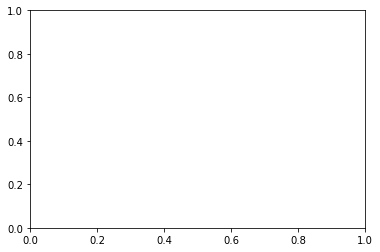

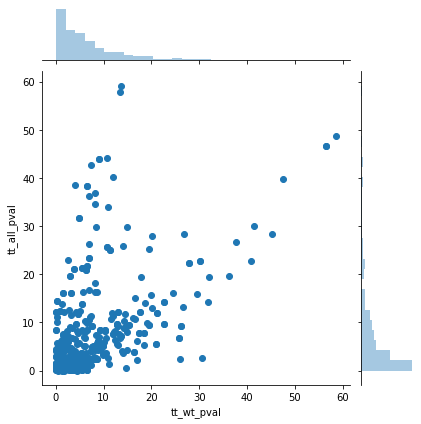

In [438]:

f = plt.gca()

sns.jointplot( x = "tt_wt_pval", y = "tt_all_pval", data = pd.concat([
    e5_stats.assign(enrichment=0),
    e1_stats.assign(enrichment=1)]))

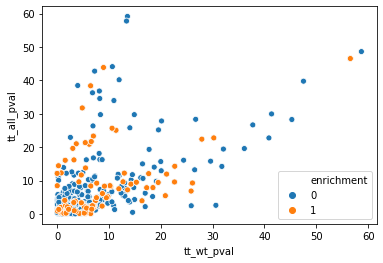

In [437]:

f = plt.gca()

sns.jointplot( x = "tt_wt_pval", y = "tt_all_pval", data = pd.concat([
    e5_stats.assign(enrichment=0),
    e1_stats.assign(enrichment=1)]))

In [416]:

for enriched_starts in [ oligos_by_exp.starts.unique() ]: 

    
    
    mutant_starts = oligos_by_exp.loc[lambda x: x.starts.isin(enriched_starts)].mutant_start.unique()
    
    #means = pd.Series(mutant_starts).apply(lambda s: oligo_types.loc[idx[s,:],:].groupby("tile_class").norm_mu.mean())
    
    def get_stats(s):
        tile_groups = oligo_types.loc[idx[s,:],:].groupby("tile_class")
        if not set(["ablation","other","wildtype",
                    "ablation60","other60","wildtype60"]).issubset(tile_groups.groups.keys()): 
            print (f"skipping position {s}")
            return pd.Series().rename(s)
        
        ablations = tile_groups.get_group("ablation")
        others = tile_groups.get_group("other")
        wildtypes = tile_groups.get_group("wildtype")
        
        ablations60 = tile_groups.get_group("ablation60")
        others60 = tile_groups.get_group("other60")
        wildtypes60 = tile_groups.get_group("wildtype60")

        wt_tt = stats.ttest_ind( ablations.norm_mu, wildtypes.norm_mu)
        all_tt = stats.ttest_ind( ablations.norm_mu, pd.concat([wildtypes.norm_mu,others.norm_mu]))

        return pd.Series({

            "mu_wt":wildtypes.norm_mu.mean(),
            "mu_ot":others.norm_mu.mean(),
            "mu_ab":ablations.norm_mu.mean(),

            "mu_wt60":wildtypes60.norm_mu.mean(),
            "mu_ot60":others60.norm_mu.mean(),
            "mu_ab60":ablations60.norm_mu.mean(),

            "tt_wt_pval":wt_tt[1],
            "tt_all_pval":wt_tt[1],

            }).rename(s)

    stats2 = pd.Series(mutant_starts, index = mutant_starts).apply(get_stats)

        
  

skipping position 1526
skipping position 8765
skipping position 18665
skipping position 27323
skipping position 28482
skipping position 33406
skipping position 36590
skipping position 37858
skipping position 39927
skipping position 45650
skipping position 48608
skipping position 51607
skipping position 52516
skipping position 55123
skipping position 56239
skipping position 64877
skipping position 65976
skipping position 76831
skipping position 77697


KeyboardInterrupt: 

HI


In [384]:
oligo_types.loc[idx[s,:],:].loc[idx[1526,"wildtype60"],:]

KeyError: (1526, 'wildtype60')

In [352]:
oligo_types.loc[idx[s,:],:].groupby("tile_class").mean()

,level_0,oligo,Unnamed: 0,index,n_bcs,n_transcripts,id,locus_ids,mutant_num,is_cand,...,mu,rep,gstart,gend,norm_mu,DLD1_WT_rank,HCT116_GEM_rank,HCT116_WT_rank,U2OS_NFKB_rank,U2OS_WT_rank
tile_class,,,,,,,,,,,,,,,,,,,,,
ablation,1812.00,28.0,1812.00,72496.75,81.062500,172.3750,28.0,30.0,0.0,True,...,2.202039,1.5,38701260.0,38701440.0,2.239584,1147.0,1228.0,1416.0,601.0,566.0
ablation60,1812.00,28.0,1812.00,72496.75,81.062500,172.3750,28.0,30.0,0.0,True,...,2.202039,1.5,38701260.0,38701440.0,2.239584,1147.0,1228.0,1416.0,601.0,566.0
other,1815.50,2118.5,1815.50,74506.75,28.421875,60.8125,2118.5,30.0,2.5,True,...,2.198083,1.5,38701260.0,38701440.0,2.251714,NaN,NaN,NaN,NaN,NaN
other60,1859.25,2120.5,1859.25,74508.75,25.765625,54.8125,2120.5,30.5,2.5,True,...,2.207467,1.5,38701275.0,38701455.0,2.250589,NaN,NaN,NaN,NaN,NaN
wildtype60,1812.00,28.0,1812.00,72496.75,81.062500,172.3750,28.0,30.0,0.0,True,...,2.202039,1.5,38701260.0,38701440.0,2.239584,1147.0,1228.0,1416.0,601.0,566.0


In [353]:
oligo_types.reset_index().tile_class.value_counts()

other         607646
other60       602324
ablation60    337354
wildtype60    186170
ablation      184888
wildtype      155137
Name: tile_class, dtype: int64

In [350]:
oligo_types.reset_index().tile_class.unique()

array(['ablation', 'other', 'wildtype', 'ablation60', 'other60',
       'wildtype60'], dtype=object)